In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

#from ImageAnalysis3 import *
print(os.getpid())

25156


<a id='0.1'></a>
# 0.1 Folders

In [2]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain


In [3]:
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'mouse_TSS_integrate_CTP13')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\reports


# Load CTP12 pb_dict

In [9]:
from ImageAnalysis3.library_tools import design
original_report_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\marker_gene_TSS\reports'
# original pb_designer:
pb_designer_filename = os.path.join(original_report_folder, 'merged_probes.pbr')
# Parse segemented list
if 'pb_designer' not in locals():
    pb_designer = design.pb_reports_class()
    pb_designer.load_from_file(pb_designer_filename)
else:
    print("pb_designer already exists in RAM, skip.")

- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\marker_gene_TSS\reports\merged_probes.pbr.
- loading cand_probes from file
- loading kept_probes from file
- 7835 filtered probes loaded
- loading sequence_dic from file
- loading map_dic from file
- loading params_dic from file
- loading check_dic from file
- loading save_file from file


In [38]:
overwrite_pb_dict = True
verbose = True
pb_dict_filename = os.path.join(report_folder, 'pb_dict.pkl')

cand_prob_nums = []
pb_dict = {}

if not os.path.exists(pb_dict_filename) or overwrite_pb_dict:
    # get genes
    print("Sort genes")
    gene_names = np.unique([_v['reg_name'].split('gene_')[1].split('_')[0] for _s, _v in pb_designer.kept_probes.items()])
    #region_inds = np.unique()
    print(f"- {len(gene_names)} genes")
    for _gene_name in sorted(gene_names):
        _sel_pbs = {_s:_v for _s, _v in pb_designer.kept_probes.items() 
                    if _v['reg_name'].split('gene_')[1].split('_')[0]==_gene_name}

        if len(_sel_pbs) > 0:
            cand_prob_nums.append(len(_sel_pbs))
            if verbose:
                print(f"-- appending region:{_gene_name} with {len(_sel_pbs)} probes")
            _splitted_pbde = design.pb_reports_class()
            _splitted_pbde.kept_probes = _sel_pbs
            pb_dict[_gene_name] = _splitted_pbde
    # sazve
    print(f"Saving pb_dict into file: {pb_dict_filename}")
    pickle.dump(pb_dict, open(pb_dict_filename, 'wb'))
else:
    print(f"Loading pb_dict from file: {pb_dict_filename}")
    pb_dict = pickle.load(open(pb_dict_filename, 'rb'))


Sort genes
- 28 genes
-- appending region:Aqp4 with 269 probes
-- appending region:Bgn with 320 probes
-- appending region:Car3 with 259 probes
-- appending region:Ctss with 195 probes
-- appending region:Cux2 with 296 probes
-- appending region:Flt1 with 270 probes
-- appending region:Gad1 with 251 probes
-- appending region:Igf2 with 285 probes
-- appending region:Lamp5 with 271 probes
-- appending region:Lratd2 with 277 probes
-- appending region:Nxph4 with 303 probes
-- appending region:Otof with 296 probes
-- appending region:Pdgfra with 270 probes
-- appending region:Ptpru with 299 probes
-- appending region:Pvalb with 298 probes
-- appending region:Rorb with 251 probes
-- appending region:Rspo1 with 288 probes
-- appending region:Slc17a7 with 291 probes
-- appending region:Slc30a3 with 215 probes
-- appending region:Slc32a1 with 291 probes
-- appending region:Sncg with 257 probes
-- appending region:Sox10 with 311 probes
-- appending region:Sst with 298 probes
-- appending regio

<IPython.core.display.Javascript object>


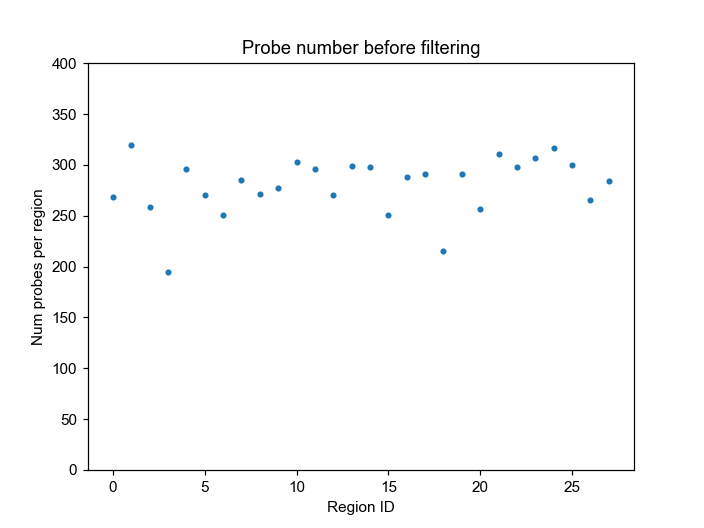

In [39]:
# number of probes histogram
fig, ax = plt.subplots()
ax.plot(cand_prob_nums, '.')
ax.set_ylabel("Num probes per region")
ax.set_xlabel("Region ID")
ax.set_title("Probe number before filtering")
ax.set_ylim([0,400])
plt.show()

In [40]:
# filter by genome counts
import ImageAnalysis3.library_tools.quality_check as qc

num_probes_kept = 300 # max num of probes kept for each region
filtered_pb_dict = qc.Screen_probe_by_hit(library_folder, pb_dict, num_probes_kept, hit_type='genome')

## filter by minimum number of probes in each region
min_num_probes = 60
removed_regions = []
for _rid, _pb_class in filtered_pb_dict.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dict[_rid])

- Screen probes by genome counts.
-- filtering region:Aqp4, directly append 269 probes
-- filtering region:Bgn, screen genome to keep 300 probes
-- filtering region:Car3, directly append 259 probes
-- filtering region:Ctss, directly append 195 probes
-- filtering region:Cux2, directly append 296 probes
-- filtering region:Flt1, directly append 270 probes
-- filtering region:Gad1, directly append 251 probes
-- filtering region:Igf2, directly append 285 probes
-- filtering region:Lamp5, directly append 271 probes
-- filtering region:Lratd2, directly append 277 probes
-- filtering region:Nxph4, screen genome to keep 300 probes
-- filtering region:Otof, directly append 296 probes
-- filtering region:Pdgfra, directly append 270 probes
-- filtering region:Ptpru, directly append 299 probes
-- filtering region:Pvalb, directly append 298 probes
-- filtering region:Rorb, directly append 251 probes
-- filtering region:Rspo1, directly append 288 probes
-- filtering region:Slc17a7, directly append 

# 3. Redo assembly

# 3.1 Encoding design

### Load CTP13 encoding with blanks

In [41]:
ctp13_codebook_blank_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mop_SE_1000_w_blanks.csv'

import pandas as pd
codebook = pd.read_csv(ctp13_codebook_blank_filename)
codebook

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order
0,1:9627926-9637875,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
1,1:9799472-9811359,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1.0
2,1:20920666-20929358,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2.0
3,1:21522568-21534512,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.0
4,1:21732182-21745770,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,B:194-195,1086,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,94.0
1061,B:195-196,1087,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,B,95.0
1062,B:196-197,1088,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,96.0
1063,B:197-198,1089,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,B,97.0


In [150]:
# compute start,end of each barcode:
_starts = [int(_n.split(':')[1].split('-')[0]) for _n in codebook['name']]
_ends = [int(_n.split(':')[1].split('-')[1]) for _n in codebook['name']]
_centers = (np.array(_starts) + np.array(_ends)) / 2
new_codebook = codebook.copy()
new_codebook['region_center'] = _centers

### use blank barcodes, assign
region_name_2_bits = {}

# extract blank:
blank_2_bits = {}
for _i, _row in new_codebook.iterrows():
    if "B:" in _row['name']:
        _code = np.array(_row[[_c for _c in new_codebook.columns if 'NDB_' in _c]].values, dtype=np.int32)
        _bits = np.where(_code)[0]
        blank_2_bits[_row['name']] = _bits
        
# for each region, find its location on chromosome:
for _reg_name, _pbde in filtered_pb_dict.items():
    print(_reg_name)
    _info_dict = list(_pbde.kept_probes.values())[0]
    _region_info = _info_dict['reg_name'].split("_")[0]
    _chr = _region_info.split(':')[0]
    _start,_end = _region_info.split(':')[1].split('-')
    _center = (int(_start) + int(_end)) / 2
    # find relative position of these marker genes in given chromosome:
    _chr_codebook = new_codebook.loc[new_codebook['chr']==_chr].reindex()
    _chr_centers = _chr_codebook['region_center'].values
    # merge and sort order:
    _merged_order = np.argsort(np.concatenate([_chr_centers,[_center]]))
    _chr_bits = [[] for _ord in _merged_order]
    _append_position = np.where(_merged_order==len(_chr_centers))[0][0]
    #print(_append_position)
    for _i, (_ind, _row) in enumerate(_chr_codebook.iterrows()):
        _chr_bits[np.where(_merged_order==_i)[0][0]] = np.where(
            np.array(_row[[_c for _c in new_codebook.columns if 'NDB_' in _c]].values, dtype=np.int32))[0]
        #print(_i, _append_position)
    # then given this order, select the best blank:
    _sel_blank = None
    _sel_dist = 0
    for _blank_name, _bits in blank_2_bits.items():
        _dist = encoding.calculate_closest_overlap([_c for _c in _chr_bits if len(_c)], 
                                                   _bits, _append_position)
        if _dist > _sel_dist:
            _sel_dist = _dist
            _sel_blank = _blank_name
            #print(_sel_blank)
    # after looping, select this blank code:
    region_name_2_bits[_reg_name] = blank_2_bits[_sel_blank]
    blank_2_bits.pop(_sel_blank)
    print("-", _chr, len(_chr_codebook), _sel_blank, _sel_dist, len(blank_2_bits))
    # update new_codebook
    #print(_reg_name, _sel_blank)
    new_codebook.loc[new_codebook['name'] == _sel_blank, 'id'] = _reg_name
    new_codebook.loc[new_codebook['name'] == _sel_blank, 'chr'] = _chr
    new_codebook.loc[new_codebook['name'] == _sel_blank, 'chr_order'] = _append_position
    new_codebook.loc[new_codebook['name'] == _sel_blank, 'region_center'] = _center
    new_codebook.loc[new_codebook['name'] == _sel_blank, 'name'] = _info_dict['reg_name'].split('_')[0] # last change name

    #break
    

Aqp4
- 18 32 B:131-132 25.0 98
Bgn
- X 7 B:100-101 8.0 97
Car3
- 3 59 B:119-120 25.0 96
Ctss
- 3 60 B:135-136 20.0 95
Cux2
- 5 56 B:189-190 16.0 94
Flt1
- 5 57 B:163-164 28.0 93
Gad1
- 2 73 B:150-151 15.0 92
Igf2
- 7 45 B:167-168 27.0 91
Lamp5
- 2 74 B:101-102 16.0 90
Lratd2
- 15 35 B:128-129 14.0 89
Nxph4
- 10 64 B:109-110 20.0 88
Otof
- 5 58 B:127-128 21.0 87
Pdgfra
- 5 59 B:137-138 15.0 86
Ptpru
- 4 61 B:152-153 30.0 85
Pvalb
- 15 36 B:198-199 16.0 84
Rorb
- 19 35 B:187-188 19.0 83
Rspo1
- 4 62 B:104-105 13.0 82
Slc17a7
- 7 46 B:140-141 15.0 81
Slc30a3
- 5 60 B:172-173 18.0 80
Slc32a1
- 2 75 B:139-140 9.0 79
Sncg
- 14 51 B:122-123 12.0 78
Sox10
- 15 37 B:158-159 12.0 77
Sst
- 16 37 B:175-176 23.0 76
Sulf2
- 2 76 B:155-156 14.0 75
Syt6
- 3 61 B:151-152 14.0 74
Tshz2
- 2 77 B:157-158 14.0 73
Vip
- 10 65 B:121-122 23.0 72
Vtn
- 11 57 B:126-127 14.0 71


In [152]:
new_codebook.loc[new_codebook['chr']=='2']

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order,region_center
76,2:3156187-3166922,77,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,2,0.0,3161554.5
77,2:4052881-4061655,78,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1.0,4057268.0
78,2:5181586-5192683,79,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2.0,5187134.5
79,2:11345065-11361468,80,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,2,3.0,11353266.5
80,2:14934135-14944278,81,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4.0,14939206.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,2:136042239-136062239,Lamp5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,54.0,136052239.0
1005,2:158600767-158620767,Slc32a1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,64.0,158610767.0
1016,2:70543072-70563072,Gad1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,24.0,70553072.0
1021,2:166145663-166165663,Sulf2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,69.0,166155663.0


In [153]:
new_codebook['name']

0          1:9627926-9637875
1          1:9799472-9811359
2        1:20920666-20929358
3        1:21522568-21534512
4        1:21732182-21745770
                ...         
1060               B:194-195
1061               B:195-196
1062               B:196-197
1063               B:197-198
1064    15:78196400-78216400
Name: name, Length: 1065, dtype: object

In [154]:
new_codebook[new_codebook['id'] == 'Aqp4']

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order,region_center
997,18:15400982-15420982,Aqp4,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,18,1.0,15410982.0


# TODO

In [167]:
# TODO: sort and save new_codebook



<IPython.core.display.Javascript object>


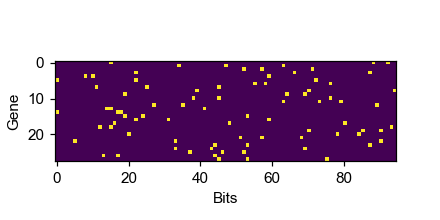

In [166]:
_mat = encoding.convert_bits_to_matrix(list(region_name_2_bits.values()))
plt.figure(figsize=(4,2))
plt.imshow(_mat)
plt.ylabel("Gene")
plt.xlabel("Bits")
plt.show()

In [170]:
# with this combinatorial, generate region_2_readout_dict
region_2_readout_filename = os.path.join(library_folder, 'region_2_readout.pkl')
if os.path.exists(region_2_readout_filename):
    region_2_readout_dict = pickle.load(open(region_2_readout_filename, 'rb'))
else:
    region_2_readout_dict = {}
    for _region, _bits in region_name_2_bits.items():
        region_2_readout_dict[_region] = [f"c{_b}" for _b in _bits]
    # save
    print(f"saving to: {region_2_readout_filename}")
    pickle.dump(region_2_readout_dict, open(region_2_readout_filename, 'wb'))
region_2_readout_dict

saving to: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\region_2_readout.pkl


{'Aqp4': ['c15', 'c88', 'c92'],
 'Bgn': ['c34', 'c47', 'c63'],
 'Car3': ['c52', 'c57', 'c71'],
 'Ctss': ['c22', 'c66', 'c87'],
 'Cux2': ['c8', 'c10', 'c59'],
 'Flt1': ['c0', 'c22', 'c72'],
 'Gad1': ['c55', 'c58', 'c76'],
 'Igf2': ['c11', 'c25', 'c45'],
 'Lamp5': ['c39', 'c70', 'c94'],
 'Lratd2': ['c19', 'c64', 'c69'],
 'Nxph4': ['c38', 'c45', 'c76'],
 'Otof': ['c63', 'c73', 'c79'],
 'Pdgfra': ['c27', 'c35', 'c89'],
 'Ptpru': ['c14', 'c15', 'c41'],
 'Pvalb': ['c0', 'c17', 'c18'],
 'Rorb': ['c19', 'c24', 'c53'],
 'Rspo1': ['c22', 'c31', 'c59'],
 'Slc17a7': ['c16', 'c48', 'c80'],
 'Slc30a3': ['c12', 'c15', 'c93'],
 'Slc32a1': ['c70', 'c85', 'c90'],
 'Sncg': ['c20', 'c78', 'c84'],
 'Sox10': ['c51', 'c57', 'c68'],
 'Sst': ['c5', 'c33', 'c90'],
 'Sulf2': ['c44', 'c53', 'c87'],
 'Syt6': ['c33', 'c43', 'c69'],
 'Tshz2': ['c37', 'c46', 'c52'],
 'Vip': ['c13', 'c17', 'c44'],
 'Vtn': ['c45', 'c53', 'c75']}

<a id='3.2'></a>
## 3.2 loading components

### primers
pick primer set 18,5

In [171]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers = library_tools.assemble.load_primers([18, 5], _primer_folder=primer_folder)

- Picked primer: ID: W1B07_primer_18
Name: W1B07_primer_18
Description: W1B07_primer_18
Number of features: 0
Seq('CACGTGGCCTCTCGCACATC')
- Picked primer: ID: W1A06_primer_5
Name: W1A06_primer_5
Description: W1A06_primer_5
Number of features: 0
Seq('TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG')


### readouts

same as CTP13

In [191]:
# load readouts:
from ImageAnalysis3.classes import _allowed_kwds
readout_type = 'combo'
_type_char = _allowed_kwds[readout_type]

ctp13_readout_dict = np.load(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\readout_usage.pkl', allow_pickle=True)

In [192]:
# Check ctp13 readout_names
_ctp13_rd_names = [_r.id for _r in ctp13_readout_dict[_type_char]]
print(_ctp13_rd_names)

['NDB_376', 'NDB_578', 'NDB_400', 'NDB_533', 'NDB_568', 'NDB_464', 'NDB_466', 'NDB_431', 'NDB_511', 'NDB_554', 'NDB_487', 'NDB_458', 'NDB_409', 'NDB_443', 'NDB_571', 'NDB_455', 'NDB_448', 'NDB_470', 'NDB_529', 'NDB_332', 'NDB_508', 'NDB_536', 'NDB_403', 'NDB_461', 'NDB_391', 'NDB_398', 'NDB_532', 'NDB_467', 'NDB_616', 'NDB_335', 'NDB_388', 'NDB_506', 'NDB_427', 'NDB_347', 'NDB_619', 'NDB_482', 'NDB_433', 'NDB_446', 'NDB_397', 'NDB_473', 'NDB_505', 'NDB_539', 'NDB_385', 'NDB_452', 'NDB_514', 'NDB_356', 'NDB_445', 'NDB_587', 'NDB_628', 'NDB_551', 'NDB_421', 'NDB_557', 'NDB_379', 'NDB_491', 'NDB_418', 'NDB_401', 'NDB_526', 'NDB_611', 'NDB_472', 'NDB_341', 'NDB_622', 'NDB_386', 'NDB_517', 'NDB_392', 'NDB_544', 'NDB_614', 'NDB_625', 'NDB_395', 'NDB_577', 'NDB_359', 'NDB_556', 'NDB_581', 'NDB_481', 'NDB_350', 'NDB_439', 'NDB_371', 'NDB_493', 'NDB_476', 'NDB_547', 'NDB_428', 'NDB_538', 'NDB_365', 'NDB_589', 'NDB_494', 'NDB_601', 'NDB_479', 'NDB_562', 'NDB_608', 'NDB_460', 'NDB_563', 'NDB_592'

In [198]:
# save
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
if not os.path.isfile(readout_usage_file) or overwrite_readout_usage:
    print('save ctp13_readout_dict')
    pickle.dump(ctp13_readout_dict, open(readout_usage_file, 'wb'))

save ctp13_readout_dict


<a id='3.3'></a>
## 3.3 assemble probes

In [199]:
reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

# params
assemble_params = {
    'primer_len':20,
    'num_readout_per_probe':4, 
}

In [201]:
# run assembly
cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dict, 
                                               region_2_readout_dict, ctp13_readout_dict, primers, 
                                               primer_len=assemble_params['primer_len'], 
                                               num_readout_per_probe=assemble_params['num_readout_per_probe'], 
                                               unique_readout_per_probe=True,
                                               rc_targets=False, overwrite=True)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['c']
--- assemblying 269 probes in region: Aqp4
--- assemblying 300 probes in region: Bgn
--- assemblying 259 probes in region: Car3
--- assemblying 195 probes in region: Ctss
--- assemblying 296 probes in region: Cux2
--- assemblying 270 probes in region: Flt1
--- assemblying 251 probes in region: Gad1
--- assemblying 285 probes in region: Igf2
--- assemblying 271 probes in region: Lamp5
--- assemblying 277 probes in region: Lratd2
--- assemblying 300 probes in region: Nxph4
--- assemblying 296 probes in region: Otof
--- assemblying 270 probes in region: Pdgfra
--- assemblying 299 probes in region: Ptpru
--- assemblying 298 probes in region: Pvalb
--- assemblying 251 probes in region: Rorb
--- assemblying 288 probes in region: Rspo1
--- assemblying 291 probes in region: Slc17a7
--- assemblying 215 probes in region: Slc30a3
--- assemblying 291 probes in region: Slc32a1
--- assemblying 257 pro

# 4.Check quality


## 4.1 Load probes

Checking procedures could restart from here

In [202]:
# folder for this library
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# candidate full-length probe filename
candidate_basename = 'candidate_probes.fasta' # old version
# load full probes
full_records = []
with open(os.path.join(library_folder, candidate_basename), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 7777


In [214]:
full_records[0]

SeqRecord(seq=Seq('CACGTGGCCTCTCGCACATCTATGCGCAAGCTATCGGACATATGCGCAAGCTAT...GAC'), id='loc_18:15400982-15420982_gene_Aqp4_pb_0_pos_67_strand_-_readouts_[NDB_455_c,NDB_455_c,NDB_455_c,NDB_455_c]_primers_[W1B07_primer_18,W1A06_primer_5]', name='loc_18:15400982-15420982_gene_Aqp4_pb_0_pos_67_strand_-_readouts_[NDB_455_c,NDB_455_c,NDB_455_c,NDB_455_c]_primers_[W1B07_primer_18,W1A06_primer_5]', description='loc_18:15400982-15420982_gene_Aqp4_pb_0_pos_67_strand_-_readouts_[NDB_455_c,NDB_455_c,NDB_455_c,NDB_455_c]_primers_[W1B07_primer_18,W1A06_primer_5]', dbxrefs=[])

### Manually input the following info to double check!

In [215]:
num_readout_per_probe = 4
primer_len=20
target_len=40

min_num_probes = 21
# merfish related
num_on_bits = 3

### 4.1.1 check primer usage

In [216]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 7777
True


### 4.1.2 check region probe number

In [217]:
reload(check)
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   species_marker = 'gene_',
                                                   min_size=min_num_probes)
print(len_check)

gene: Aqp4 -> 269
gene: Bgn -> 300
gene: Car3 -> 259
gene: Ctss -> 195
gene: Cux2 -> 296
gene: Flt1 -> 270
gene: Gad1 -> 251
gene: Igf2 -> 285
gene: Lamp5 -> 271
gene: Lratd2 -> 277
gene: Nxph4 -> 300
gene: Otof -> 296
gene: Pdgfra -> 270
gene: Ptpru -> 299
gene: Pvalb -> 298
gene: Rorb -> 251
gene: Rspo1 -> 288
gene: Slc17a7 -> 291
gene: Slc30a3 -> 215
gene: Slc32a1 -> 291
gene: Sncg -> 257
gene: Sox10 -> 300
gene: Sst -> 298
gene: Sulf2 -> 300
gene: Syt6 -> 300
gene: Tshz2 -> 300
gene: Vip -> 266
gene: Vtn -> 284
True


<IPython.core.display.Javascript object>


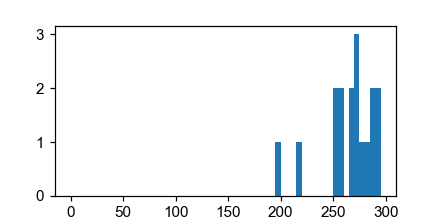

In [218]:
plt.figure(figsize=(4,2))
plt.hist(list(reg_size_dic.values()), bins=np.arange(0,300,5))
plt.show()

### 4.1.3 check readout usage for each gene

In [219]:
reload(check)
check_readout_dict = pickle.load(open(os.path.join(library_folder, 'readout_usage.pkl'), 'rb'))

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, check_readout_dict, 
                                                                     total_readout_num=num_on_bits)
print(reg2readout_check)

Aqp4 -> ['NDB_455', 'NDB_460', 'NDB_436']
Bgn -> ['NDB_619', 'NDB_587', 'NDB_392']
Car3 -> ['NDB_379', 'NDB_611', 'NDB_581']
Ctss -> ['NDB_403', 'NDB_625', 'NDB_608']
Cux2 -> ['NDB_511', 'NDB_487', 'NDB_341']
Flt1 -> ['NDB_376', 'NDB_403', 'NDB_481']
Gad1 -> ['NDB_401', 'NDB_472', 'NDB_493']
Igf2 -> ['NDB_458', 'NDB_398', 'NDB_356']
Lamp5 -> ['NDB_473', 'NDB_556', 'NDB_604']
Lratd2 -> ['NDB_332', 'NDB_544', 'NDB_359']
Nxph4 -> ['NDB_397', 'NDB_356', 'NDB_493']
Otof -> ['NDB_392', 'NDB_350', 'NDB_428']
Pdgfra -> ['NDB_467', 'NDB_482', 'NDB_563']
Ptpru -> ['NDB_571', 'NDB_455', 'NDB_539']
Pvalb -> ['NDB_376', 'NDB_470', 'NDB_529']
Rorb -> ['NDB_332', 'NDB_391', 'NDB_491']
Rspo1 -> ['NDB_403', 'NDB_506', 'NDB_341']
Slc17a7 -> ['NDB_448', 'NDB_628', 'NDB_538']
Slc30a3 -> ['NDB_409', 'NDB_455', 'NDB_629']
Slc32a1 -> ['NDB_556', 'NDB_479', 'NDB_592']
Sncg -> ['NDB_508', 'NDB_547', 'NDB_601']
Sox10 -> ['NDB_557', 'NDB_611', 'NDB_577']
Sst -> ['NDB_464', 'NDB_347', 'NDB_592']
Sulf2 -> ['NDB_51

### 4.1.4 check readout usage in the library

In [220]:
reload(check)
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    check_readout_dict, primer_len=primer_len, 
                                                                    target_len=target_len,
                                                                    probe_readout_num=num_readout_per_probe)
print(readout2reg_check)

-- extracting probes from >region:Aqp4, region:Bgn, region:Car3, region:Ctss, region:Cux2, region:Flt1, region:Gad1, region:Igf2, region:Lamp5, region:Lratd2, region:Nxph4, region:Otof, region:Pdgfra, region:Ptpru, region:Pvalb, region:Rorb, region:Rspo1, region:Slc17a7, region:Slc30a3, region:Slc32a1, region:Sncg, region:Sox10, region:Sst, region:Sulf2, region:Syt6, region:Tshz2, region:Vip, region:Vtn, {'NDB_455': ['Aqp4', 'Aqp4', 'Aqp4', 'Aqp4', 'Ptpru', 'Ptpru', 'Ptpru', 'Ptpru', 'Slc30a3', 'Slc30a3', 'Slc30a3', 'Slc30a3'], 'NDB_460': ['Aqp4', 'Aqp4', 'Aqp4', 'Aqp4'], 'NDB_436': ['Aqp4', 'Aqp4', 'Aqp4', 'Aqp4'], 'NDB_619': ['Bgn', 'Bgn', 'Bgn', 'Bgn'], 'NDB_587': ['Bgn', 'Bgn', 'Bgn', 'Bgn'], 'NDB_392': ['Bgn', 'Bgn', 'Bgn', 'Bgn', 'Otof', 'Otof', 'Otof', 'Otof'], 'NDB_379': ['Car3', 'Car3', 'Car3', 'Car3', 'Tshz2', 'Tshz2', 'Tshz2', 'Tshz2'], 'NDB_611': ['Car3', 'Car3', 'Car3', 'Car3', 'Sox10', 'Sox10', 'Sox10', 'Sox10'], 'NDB_581': ['Car3', 'Car3', 'Car3', 'Car3'], 'NDB_403': ['C

### 4.1.5 check bewteen probes

In [243]:
# construct internal map
reload(check)
if 'int_map' not in locals:
    int_map = check._construct_internal_map(full_records, library_folder, save=False) 
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(
    readout_reg_dic, reg_size_dic, int_map, 
    ctp13_readout_dict)
print(readout_count_check)

In [245]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, 
                                                          primer_len=primer_len, 
                                                          target_len=target_len)

--- Sequence:loc_15:79155240-79175240_gene_Sox10_pb_257_pos_17495_strand_-_readouts_[NDB_577_c,NDB_577_c,NDB_577_c,NDB_577_c]_primers_[W1B07_primer_18,W1A06_primer_5] got hits:54, dumped
--- Sequence:loc_15:79155240-79175240_gene_Sox10_pb_259_pos_17636_strand_-_readouts_[NDB_611_c,NDB_611_c,NDB_611_c,NDB_611_c]_primers_[W1B07_primer_18,W1A06_primer_5] got hits:52, dumped
-- total probes removed by internal screening: 2


In [225]:
# clear memory
del(int_map)

### 4.1.6 check from previous ctp11+13:

In [246]:
ctp11_table = library_tools.design.countTable(
    save_file=os.path.join(reference_folder, 'ctp11_genome_17w.npy'), 
    word=17)
ctp11_table.load()

# check probes against ctp11
kept_records, removed_count = check._check_between_probes(kept_records, ctp11_table, 
                                                          primer_len=primer_len, 
                                                          target_len=target_len)

-- total probes removed by internal screening: 0


In [252]:
%%time
# construct ctp13 table:
ctp13_table_filename = os.path.join(reference_folder, 'ctp13_genome_17w.npy')
overwrite_table = False

if not os.path.exists(ctp13_table_filename) or overwrite_table:
    # library
    _library_filenames = [
        os.path.join(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000', 
                     'blast_full_probes.fasta')]
    print(len(_library_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=ctp13_table_filename, 
                       sparse=False)
    ct.verbose=True

    ct.read(_library_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=44) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {ctp13_table_filename} already exist, skip.")

1
- Start multi-processing comsume 115776 sequences 44 threads, finish in 37.187s
- Total sequences loaded: 14587776
Time to compute unique and clip: 3.470588207244873
Time to update matrix: 6.109556198120117
- start saving to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\ctp13_genome_17w.npy


In [253]:
ctp13_table = library_tools.design.countTable(
    save_file=os.path.join(reference_folder, 'ctp13_genome_17w.npy'), 
    word=17)
ctp13_table.load()

# check probes against ctp13
kept_records, removed_count = check._check_between_probes(kept_records, ctp13_table, 
                                                          primer_len=primer_len, 
                                                          target_len=target_len)

-- total probes removed by internal screening: 0


### 4.1.6 finish checking, save

In [254]:
print(len(kept_records), len(cand_probes))

7775 7777


In [256]:
kept_records[0].id

'loc_18:15400982-15420982_gene_Aqp4_pb_0_pos_67_strand_-_readouts_[NDB_455_c,NDB_455_c,NDB_455_c,NDB_455_c]_primers_[W1B07_primer_18,W1A06_primer_5]'

In [257]:
# add two C at the end to fill 162nt 
from copy import copy

_extended_kept_records = []
for _record in kept_records:
    _new_record = copy(_record)
    _new_record.seq = _record.seq + Seq('CC')
    _extended_kept_records.append(_new_record)

In [258]:
len(_new_record)

162

In [259]:
# save _extended_kept_records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(_extended_kept_records, output_handle, "fasta")

In [260]:
del kept_records

## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```

In [261]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)

<module 'ImageAnalysis3.library_tools.quality_check' from 'E:\\Users\\puzheng_new\\Documents\\Chromatin_Analysis_Scripts\\Library_design\\CTP-14-human_brain_genome\\..\\..\\..\\..\\Documents\\ImageAnalysis3\\library_tools\\quality_check.py'>

In [262]:
if 'kept_records' not in locals() or len(kept_records) == 0:
    kept_records = []
    with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'r') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            kept_records.append(record)
print(len(kept_records))
print(len(kept_records[0]))

7775
162


In [263]:
blast_database = os.path.join(reference_folder, 'blast_database', 'GRCm38_ensembl')

check.Blast_probes(kept_records, library_folder, num_threads=44, 
                   blast_db=blast_database, blast_evalue=100, overwrite=True)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\blast_database\GRCm38_ensembl
-- number of probes loaded: 7775
-- processing region: Aqp4 with 269 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\blast\probe_gene_Aqp4.fasta
--- *blasting region: Aqp4
--- total time for blast Aqp4: 14.824s.
-- processing region: Bgn with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\blast\probe_gene_Bgn.fasta
--- *blasting region: Bgn
--- total time for blast Bgn: 13.706s.
-- processing region: Car3 with 259 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\blast\probe_gene_Car3.fasta
--- *blasting region: Car3
--- total time for blast Car3: 9.896s.
-- processing region: Ctss with 195 probes
--- *writing file: \\10.245.74.212

### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [264]:
# screen
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
num_probes_per_region = 120
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(
    library_folder, 
    num_probes_per_region,
    keep_mode='center',
    hard_thres=target_len,
    soft_count_th=50,
    )

- Number of probes loaded: 7775
- Number of regions in this library: 28
-- checking probes in region: Aqp4
--- gene=Aqp4, id=39 removed by soft count = 100
--- gene=Aqp4, id=112 removed by soft count = 429
--- gene=Aqp4, id=142 removed by soft count = 52
--- gene=Aqp4, id=175 removed by soft count = 83
--- number of probes: 269 , kept by blast: 265 , if remove dups: 265
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: Bgn
--- gene=Bgn, id=47 removed by soft count = 99
--- gene=Bgn, id=112 removed by soft count = 58
--- gene=Bgn, id=120 removed by soft count = 80
--- number of probes: 300 , kept by blast: 297 , if remove dups: 296
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: Car3
--- gene=Car3, id=35 removed by soft count = 583
--- gene=Car3, id=36 removed by soft count = 131
--- number of probes: 259 , kept by bl

--- gene=Sst, id=104 removed by soft count = 218
--- gene=Sst, id=107 removed by soft count = 998
--- gene=Sst, id=108 removed by soft count = 806
--- gene=Sst, id=113 removed by soft count = 52
--- gene=Sst, id=271 removed by soft count = 484
--- gene=Sst, id=272 removed by soft count = 453
--- gene=Sst, id=273 removed by soft count = 95
--- number of probes: 298 , kept by blast: 291 , if remove dups: 291
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: Sulf2
--- gene=Sulf2, id=19 removed by soft count = 74
--- gene=Sulf2, id=63 removed by hard count = 3
--- number of probes: 300 , kept by blast: 298 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: Syt6
--- number of probes: 300 , kept by blast: 300 , if remove dups: 300
--- remove duplicated probes
--- keep probes in the center
-- number of pr

# 5. Summary Table and plots

In [4]:
import pandas as pd
save_folder = os.path.join(library_folder, 'Summary_tables')

if not os.path.exists(save_folder):
    print(f"Create save_folder: {save_folder}")
    os.makedirs(save_folder)
else:
    print(f"Use save_folder: {save_folder}")

Create save_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\Summary_tables


In [7]:
# laod encoding
# summarize total readout usage
encoding_folder = os.path.join(library_folder, f'Encoding_design')
print(encoding_folder)
#region_2_bits = pickle.load(open(os.path.join(encoding_folder, 'region_2_bits.pkl'), 'rb'))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\Encoding_design


In [9]:
# load probes
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
probes = []
final_pb_filename = os.path.join(library_folder, 'blast_full_probes.fasta')

with open(final_pb_filename, 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        probes.append(record)

In [10]:
# load region names and real coordinates
region_2_names = {}
region_2_coords = {}
for _pb in probes:
    _reg = _pb.id.split('loc_')[1].split('_')[0]
    _start, _end = _reg.split(':')[1].split('-')
    # gene info
    _gene = _pb.id.split('gene_')[1].split('_')[0]
    _pb_pos = int(_pb.id.split('pos_')[1].split('_')[0]) + int(_start)
    
    if _gene not in region_2_names:
        region_2_names[_gene] = _reg
    if _gene not in region_2_coords:
        region_2_coords[_gene] = [_pb_pos]
    else:
        region_2_coords[_gene].append(_pb_pos)
print(region_2_names)

{'Aqp4': '18:15400982-15420982', 'Bgn': 'X:73473602-73493602', 'Car3': '3:14853512-14873512', 'Ctss': '3:95516786-95536786', 'Cux2': '5:122040102-122060102', 'Flt1': '5:147716011-147736011', 'Gad1': '2:70543072-70563072', 'Igf2': '7:142656816-142676816', 'Lamp5': '2:136042239-136062239', 'Lratd2': '15:60843778-60863778', 'Nxph4': '10:127524559-127544559', 'Otof': '5:30451932-30471932', 'Pdgfra': '5:75142292-75162292', 'Ptpru': '4:131828288-131848288', 'Pvalb': '15:78196400-78216400', 'Rorb': '19:19101196-19121196', 'Rspo1': '4:124976430-124996430', 'Slc17a7': '7:45153949-45173949', 'Slc30a3': '5:31098237-31118237', 'Slc32a1': '2:158600767-158620767', 'Sncg': '14:34364789-34384789', 'Sox10': '15:79155240-79175240', 'Sst': '16:23880958-23900958', 'Sulf2': '2:166145663-166165663', 'Syt6': '3:103565231-103585231', 'Tshz2': '2:169623013-169643013', 'Vip': '10:5629218-5649218', 'Vtn': '11:78489091-78509091'}


In [11]:
# generate dict
pb_len = 42
min_probe_num = 10

region_2_probeInfo = {}
for _gene in region_2_coords:
    _name = region_2_names[_gene]
    _chr = _name.split(':')[0]
    _coords = region_2_coords[_gene]
    if len(_coords) < min_probe_num:
        continue
    _info = f"{_chr}:{np.min(_coords)}-{np.max(_coords)+pb_len}"
    region_2_probeInfo[_gene] = _info

In [12]:
# laod encoding
# summarize total readout usage
region_2_readout_dict = pickle.load(open(os.path.join(library_folder, 'region_2_readout.pkl'), 'rb'))
print(region_2_readout_dict)
region_2_readout_dict = {
    _k.replace('_enhancer','-enhancer'):_v for _k,_v in region_2_readout_dict.items()
}

{'Aqp4': ['c15', 'c88', 'c92'], 'Bgn': ['c34', 'c47', 'c63'], 'Car3': ['c52', 'c57', 'c71'], 'Ctss': ['c22', 'c66', 'c87'], 'Cux2': ['c8', 'c10', 'c59'], 'Flt1': ['c0', 'c22', 'c72'], 'Gad1': ['c55', 'c58', 'c76'], 'Igf2': ['c11', 'c25', 'c45'], 'Lamp5': ['c39', 'c70', 'c94'], 'Lratd2': ['c19', 'c64', 'c69'], 'Nxph4': ['c38', 'c45', 'c76'], 'Otof': ['c63', 'c73', 'c79'], 'Pdgfra': ['c27', 'c35', 'c89'], 'Ptpru': ['c14', 'c15', 'c41'], 'Pvalb': ['c0', 'c17', 'c18'], 'Rorb': ['c19', 'c24', 'c53'], 'Rspo1': ['c22', 'c31', 'c59'], 'Slc17a7': ['c16', 'c48', 'c80'], 'Slc30a3': ['c12', 'c15', 'c93'], 'Slc32a1': ['c70', 'c85', 'c90'], 'Sncg': ['c20', 'c78', 'c84'], 'Sox10': ['c51', 'c57', 'c68'], 'Sst': ['c5', 'c33', 'c90'], 'Sulf2': ['c44', 'c53', 'c87'], 'Syt6': ['c33', 'c43', 'c69'], 'Tshz2': ['c37', 'c46', 'c52'], 'Vip': ['c13', 'c17', 'c44'], 'Vtn': ['c45', 'c53', 'c75']}


In [13]:
# load used readouts
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
readout_dict = pickle.load(open(readout_usage_file, 'rb'))

## bit_2_readout

In [14]:
dtype_dict = {_v:_k for _k,_v in ia.classes._allowed_kwds.items()}

for _dtype, _records in readout_dict.items():
    
    bit_readout_df = pd.DataFrame([[_i+1, _r.id] for _i, _r in enumerate(_records)], columns=['Bit','ReadoutName'])
    save_filename = os.path.join(save_folder, f'CTP14-replace_ctp12_readouts.csv')
    print(save_filename)
    bit_readout_df.to_csv(save_filename, index=False)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\Summary_tables\CTP14-replace_ctp12_readouts.csv


In [15]:
bit_readout_df

,Bit,ReadoutName
0,1,NDB_376
1,2,NDB_578
2,3,NDB_400
3,4,NDB_533
4,5,NDB_568
...,...,...
90,91,NDB_592
91,92,NDB_368
92,93,NDB_436
93,94,NDB_629


# Codebook

In [16]:
region_2_readout_dict

{'Aqp4': ['c15', 'c88', 'c92'],
 'Bgn': ['c34', 'c47', 'c63'],
 'Car3': ['c52', 'c57', 'c71'],
 'Ctss': ['c22', 'c66', 'c87'],
 'Cux2': ['c8', 'c10', 'c59'],
 'Flt1': ['c0', 'c22', 'c72'],
 'Gad1': ['c55', 'c58', 'c76'],
 'Igf2': ['c11', 'c25', 'c45'],
 'Lamp5': ['c39', 'c70', 'c94'],
 'Lratd2': ['c19', 'c64', 'c69'],
 'Nxph4': ['c38', 'c45', 'c76'],
 'Otof': ['c63', 'c73', 'c79'],
 'Pdgfra': ['c27', 'c35', 'c89'],
 'Ptpru': ['c14', 'c15', 'c41'],
 'Pvalb': ['c0', 'c17', 'c18'],
 'Rorb': ['c19', 'c24', 'c53'],
 'Rspo1': ['c22', 'c31', 'c59'],
 'Slc17a7': ['c16', 'c48', 'c80'],
 'Slc30a3': ['c12', 'c15', 'c93'],
 'Slc32a1': ['c70', 'c85', 'c90'],
 'Sncg': ['c20', 'c78', 'c84'],
 'Sox10': ['c51', 'c57', 'c68'],
 'Sst': ['c5', 'c33', 'c90'],
 'Sulf2': ['c44', 'c53', 'c87'],
 'Syt6': ['c33', 'c43', 'c69'],
 'Tshz2': ['c37', 'c46', 'c52'],
 'Vip': ['c13', 'c17', 'c44'],
 'Vtn': ['c45', 'c53', 'c75']}

In [18]:
# generate the codebook
codebook = pd.DataFrame(columns=['name','id']+[_r.id for _r in readout_dict['c']])
# decide region ids first
codebook['id'] = list(region_2_probeInfo.keys())
# region names
codebook['name'] = [region_2_probeInfo[str(_gene)] for _gene in codebook['id']]
# code
max_bit = np.max([np.max([int(_b[1:]) for _b in _bits]) 
                  for _gname, _bits in region_2_readout_dict.items()]) + 1
for _gene in codebook['id']:
    _bits = region_2_readout_dict[_gene]
    binary_code = []
    for _i in range(max_bit):
        if f"c{_i}" in _bits:
            binary_code.append(1)
        else:
            binary_code.append(0)
    #print(_gene)
    codebook.loc[codebook['id']==_gene, codebook.columns[2:]] = binary_code
    #codebook.loc[codebook['name']==_gene,'id'] = int(_bits[0].split('u')[1])

In [19]:
codebook

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,18:15406622-15415388,Aqp4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,X:73479128-73488153,Bgn,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3:14858911-14868170,Car3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3:95520266-95533198,Ctss,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,5:122046110-122054114,Cux2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5:147721809-147730312,Flt1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2:70548084-70558079,Gad1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7:142662059-142671622,Igf2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2:136047398-136057164,Lamp5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,15:60849388-60858243,Lratd2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# sanity check
codebook.values[:,2:].sum(1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3], dtype=object)

In [21]:
from scipy.spatial.distance import pdist, squareform
dist_mat = squareform(pdist(codebook.values[:,2:].astype(np.int32)))**2

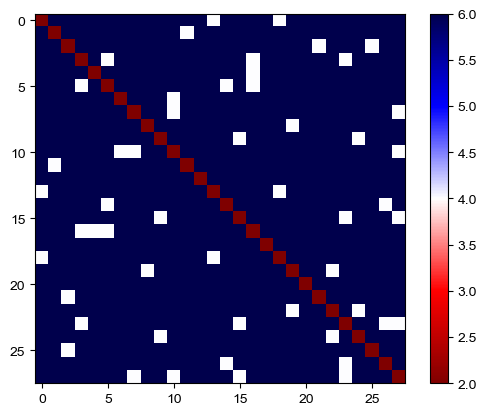

In [22]:
%matplotlib inline
fig, ax = plt.subplots()
_pf = ax.imshow(dist_mat, vmin=2, vmax=6, 
                cmap='seismic_r', interpolation=None)
plt.colorbar(_pf)
plt.show()

## append chromosome info

In [23]:
# add chromosome info
codebook['chr'] = [_n.split(':')[0] for _n in codebook['name']]
for _chr in np.unique(codebook['chr']):
    _chr_codebook = codebook.loc[codebook['chr']==_chr]
    _chr_reg_info = [np.mean([int(_loc) for _loc in _n.split(':')[1].split('-')]) for _n in _chr_codebook['name']]
    _chr_orders = np.array(_chr_reg_info).argsort().argsort().astype(np.int32)
    codebook.loc[codebook['chr']==_chr, 'chr_order'] = _chr_orders
# sort id
#codebook.sort_values('id', inplace=True)


In [24]:
lib_name = os.path.basename(library_folder)

In [26]:
codebook_save_filename = os.path.join(save_folder, f'CTP14-{lib_name}_codebook_probe.csv')
if not os.path.exists(codebook_save_filename):
    print(codebook_save_filename)
    codebook.to_csv(codebook_save_filename,index=None)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\Summary_tables\CTP14-mouse_TSS_integrate_CTP13_codebook_probe.csv


## Merge codebook with CTP13

In [6]:
import pandas as pd
save_folder = os.path.join(library_folder, 'Summary_tables')
lib_name = os.path.basename(library_folder)
codebook_save_filename = os.path.join(save_folder, f'CTP14-{lib_name}_codebook_probe.csv')

codebook = pd.read_csv(codebook_save_filename)
codebook

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order
0,18:15406622-15415388,Aqp4,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,18,0.0
1,X:73479128-73488153,Bgn,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,0.0
2,3:14858911-14868170,Car3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0.0
3,3:95520266-95533198,Ctss,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3,1.0
4,5:122046110-122054114,Cux2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,3.0
5,5:147721809-147730312,Flt1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,4.0
6,2:70548084-70558079,Gad1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.0
7,7:142662059-142671622,Igf2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,1.0
8,2:136047398-136057164,Lamp5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,1.0
9,15:60849388-60858243,Lratd2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,0.0


In [7]:
# load CTP-13
ctp13_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mop_SE_1000_w_blanks.csv', header=0)


In [95]:
from scipy.spatial.distance import pdist, cdist, squareform

# screen blank code with this codebook:
ctp13_base_codebook = ctp13_codebook.loc[ctp13_codebook['chr'] != 'B']
ctp13_blank_codebook = ctp13_codebook.loc[ctp13_codebook['chr'] == 'B']


merged_codebook = pd.concat([codebook, ctp13_base_codebook])
coding_mat = merged_codebook[[_c for _c in merged_codebook.columns if 'NDB' in _c]].values.astype(np.int32)
for _i, _b in ctp13_blank_codebook.iterrows():
    _coding = _b[[_c for _c in merged_codebook.columns if 'NDB' in _c]].values.astype(np.int32)
    _dists = cdist([_coding], coding_mat)[0]**2
    # if Hamming distance larger than 4, append
    if np.min(_dists) >= 4:
        #print(_i)
        merged_codebook = pd.concat([merged_codebook, _b.to_frame().T])
        print(len(merged_codebook))
        # update coding mat
        coding_mat = merged_codebook[[_c for _c in merged_codebook.columns if 'NDB' in _c]].values.astype(np.int32)
        

995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065


In [97]:
merged_codebook

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order
0,18:15406622-15415388,Aqp4,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,18,0.0
1,X:73479128-73488153,Bgn,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,0.0
2,3:14858911-14868170,Car3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0.0
3,3:95520266-95533198,Ctss,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3,1.0
4,5:122046110-122054114,Cux2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,B:193-194,1085,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,93.0
1060,B:194-195,1086,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,94.0
1061,B:195-196,1087,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,B,95.0
1062,B:196-197,1088,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,96.0


In [99]:
np.sum(merged_codebook['chr']=='B')

71

In [102]:
# save this merged codebook
merged_codebook_save_filename = os.path.join(save_folder, f'CTP14-{lib_name}_codebook_probe_merged_ctp13.csv')
if not os.path.exists(merged_codebook_save_filename):
    print(merged_codebook_save_filename)
    merged_codebook.to_csv(merged_codebook_save_filename,index=None)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\mouse_TSS_integrate_CTP13\Summary_tables\CTP14-mouse_TSS_integrate_CTP13_codebook_probe_merged_ctp13.csv
